In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

# Get data

In [3]:
!aws s3 cp ccs-prediction/ccs_base_experimental.xlsx ../data/ccs_base_experimental.xlsx

download: ccs-prediction/ccs_base_experimental.xlsx to ../data/ccs_base_experimental.xlsx


In [4]:
ccsbase = pd.read_excel("../data/ccs_base_experimental.xlsx", index_col=0)

In [5]:
ccsbase["CCS Type"].unique()

array(['DT', 'TW', 'TIMS'], dtype=object)

In [6]:
ccsbase.Adduct.value_counts()

Adduct
[M+H]+               6025
[M+Na]+              3657
[M-H]-               2644
[M+NH4]+             1193
[M+K]+               1170
[M+H-H2O]+            989
[M+CH3COO]-           298
[M+Na-2H]-            166
[M+HCOO]-             155
[M]+                  109
[M+2Na-H]+             87
[M+Cl]-                59
[M+H-2H2O]+            33
[2M-H]-                32
[M+K-H+HCOO]-          31
[M-H2O-H]-             31
[2M+Na]+               29
[M-H-CO2]-             28
[M+Na-H+Cl]-           24
[M+Na-H+HCOO]-         24
[M-2H]2-               19
[M+2H]2+               15
[M+Na-H2O]+            13
[M-SO3-H]-             11
[M-SO3-2H2O+H]+        11
[M+2K]2+               11
[2M+H]+                10
[M-SO3-H2O-H]-         10
[M+Rb]+                10
[M+K-H+Cl]-            10
[M+H2O-H]-              9
[M+K-2H]-               9
[M+H-NH3]+              9
[M+Li]+                 7
[M+3H]3+                7
[M+H3C2O2]-             7
[M-SO3-H2O+H]+          6
[M-SO3-3H2O+H]+         4
[M-H2

In [7]:
permitted_adducts = [
    "[M+H]+",
    "[M+Na]+",
    "[M-H]-",
    "[M+NH4]+",
    "[M+K]+",
    "[M+H-H2O]+",
    "[2M-H]-",
    "[2M+Na]+",
    "[2M+H]+",
]
ccsbase = ccsbase.loc[ccsbase.Adduct.isin(permitted_adducts)].copy()

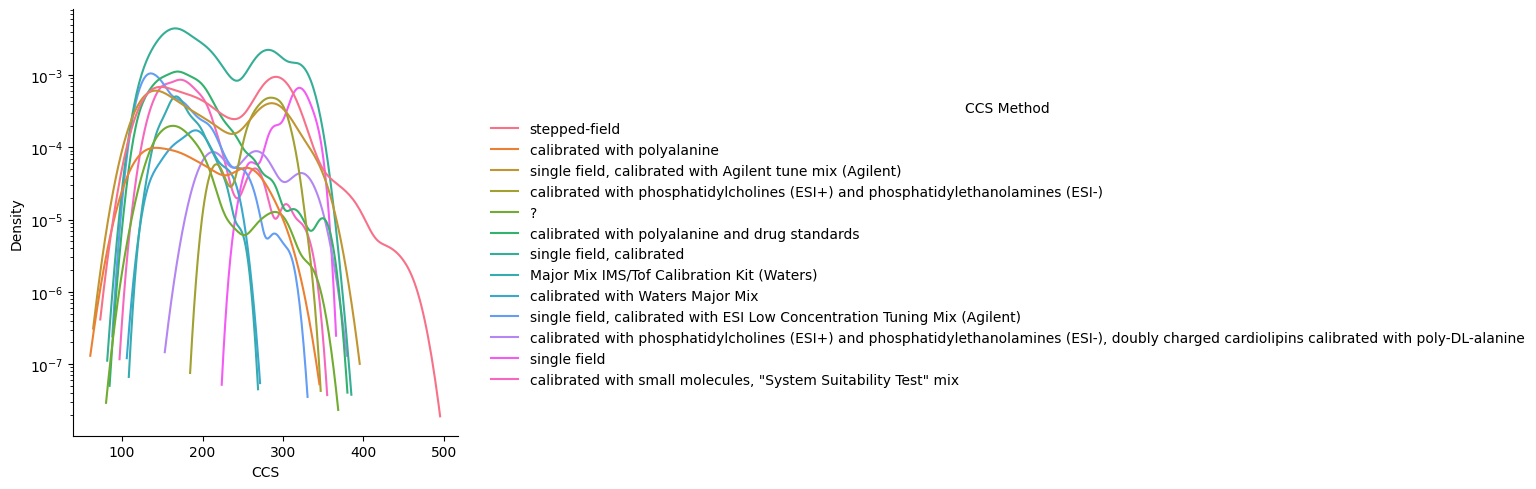

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.displot(data=ccsbase, x="CCS", hue="CCS Method", kind="kde")
plt.yscale("log")

<Axes: ylabel='Frequency'>

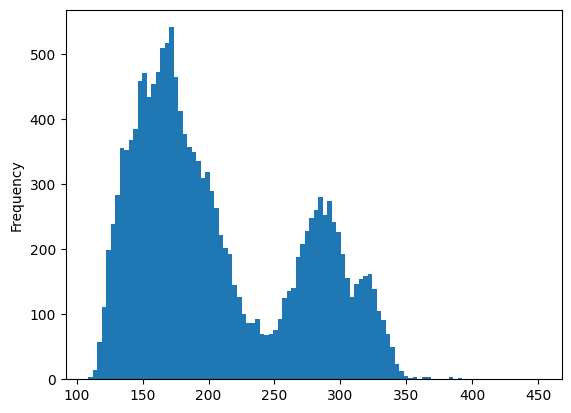

In [9]:
ccsbase.CCS.plot.hist(bins=100)

In [10]:
ccsbase.value_counts(["Adduct", "CCS Method"])

Adduct      CCS Method                                                                                                                                   
[M+H]+      single field, calibrated                                                                                                                         2163
[M+Na]+     single field, calibrated                                                                                                                         1802
[M+H]+      calibrated with polyalanine and drug standards                                                                                                   1278
[M+K]+      single field, calibrated                                                                                                                          959
[M-H]-      single field, calibrated                                                                                                                          949
[M+H-H2O]+  single field, calibrated

In [11]:
ccsbase.columns

Index(['ID', 'Name', 'Adduct', 'CCS', 'M/Z', 'SMI', 'Type', 'Z', 'Ref',
       'CCS Type', 'CCS Method'],
      dtype='object')

In [12]:
ccsbase.rename(columns={"SMI": "SMILES"}, inplace=True)

In [13]:
ccsbase = ccsbase.loc[ccsbase.SMILES.notna()]

In [14]:
ccsbase.Adduct.value_counts()

Adduct
[M+H]+        5851
[M+Na]+       3544
[M-H]-        2406
[M+K]+        1124
[M+NH4]+      1041
[M+H-H2O]+     980
[2M-H]-         32
[2M+Na]+        29
[2M+H]+         10
Name: count, dtype: int64

In [15]:
ccsbase = ccsbase.loc[~(ccsbase.SMILES.str.contains(".", regex=False))]

In [16]:
ccsbase.Adduct.value_counts()

Adduct
[M+H]+        5479
[M+Na]+       3526
[M-H]-        2400
[M+K]+        1124
[M+NH4]+      1041
[M+H-H2O]+     969
[2M-H]-         32
[2M+Na]+        29
[2M+H]+         10
Name: count, dtype: int64

# De-duplicate smiles

In [17]:
ccsbase.duplicated(subset=["SMILES", "Adduct"]).sum()

3665

In [18]:
value_counts = ccsbase.value_counts(["SMILES", "Adduct"])

In [19]:
value_counts.reset_index().Adduct.value_counts()

Adduct
[M+H]+        4068
[M+Na]+       2643
[M-H]-        1773
[M+K]+        1111
[M+H-H2O]+     939
[M+NH4]+       340
[2M-H]-         32
[2M+Na]+        29
[2M+H]+         10
Name: count, dtype: int64

In [20]:
ccsbase["smiles_adduct"] = ccsbase.apply(lambda x: f"{x.SMILES}_{x.Adduct}", axis=1)

In [21]:
ccsbase["value_counts"] = ccsbase.smiles_adduct.map(
    ccsbase.smiles_adduct.value_counts()
)

In [22]:
def mean_abs_dev(x):
    return (x - x.mean()).abs().mean()

In [23]:
for name, df in ccsbase.groupby("smiles_adduct"):
    print(df.CCS)
    break

11616    206.32
Name: CCS, dtype: float64


In [24]:
ccsbase["mean_absolute_deviation"] = ccsbase.groupby("smiles_adduct").CCS.transform(
    mean_abs_dev
)

<Axes: >

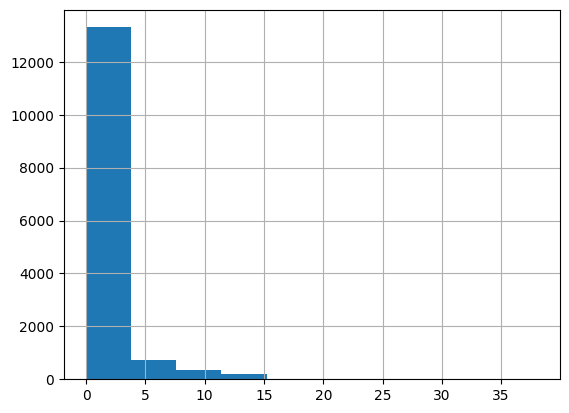

In [25]:
ccsbase["mean_absolute_deviation"].hist(bins=10)

In [26]:
ccsbase = ccsbase.loc[ccsbase["mean_absolute_deviation"] < 5]

In [27]:
ccsbase.Adduct.value_counts()

Adduct
[M+H]+        5318
[M+Na]+       3149
[M-H]-        2346
[M+K]+        1124
[M+H-H2O]+     967
[M+NH4]+       642
[2M-H]-         32
[2M+Na]+        29
[2M+H]+         10
Name: count, dtype: int64

In [28]:
ccsbase.shape

(13617, 14)

<Axes: ylabel='Frequency'>

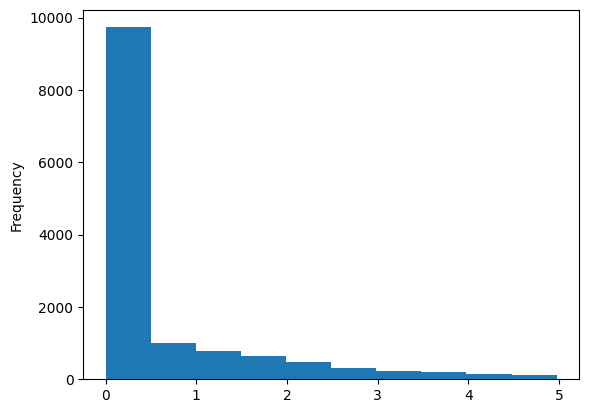

In [29]:
ccsbase["mean_absolute_deviation"].plot.hist(bins=10)

In [30]:
ccsbase["mean_CCS"] = ccsbase.groupby("smiles_adduct").CCS.transform("mean")

In [31]:
deduplicated_ccsbase = ccsbase.copy()
deduplicated_ccsbase.drop_duplicates(subset=["smiles_adduct"], inplace=True)

ccsbase.drop_duplicates(subset=["smiles_adduct", "CCS"], inplace=True)

In [32]:
ccsbase.Adduct.value_counts(), deduplicated_ccsbase.Adduct.value_counts()

(Adduct
 [M+H]+        5297
 [M+Na]+       3144
 [M-H]-        2339
 [M+K]+        1122
 [M+H-H2O]+     967
 [M+NH4]+       642
 [2M-H]-         32
 [2M+Na]+        29
 [2M+H]+         10
 Name: count, dtype: int64,
 Adduct
 [M+H]+        3998
 [M+Na]+       2591
 [M-H]-        1751
 [M+K]+        1111
 [M+H-H2O]+     938
 [M+NH4]+       320
 [2M-H]-         32
 [2M+Na]+        29
 [2M+H]+         10
 Name: count, dtype: int64)

In [35]:
deduplicated_ccsbase[["SMILES", "Adduct", "mean_CCS", "Type", "CCS Type"]].rename(
    columns={
        "mean_CCS": "CCS",
        "Type": "mol_type",
        "SMILES": "smiles",
        "CCS Type": "ccs_type",
    }
).to_parquet(
    "ccs-prediction/ccs_base_experimental_clean.parquet"
)

ccsbase[["SMILES", "Adduct", "CCS", "CCS Method", "Type", "CCS Type"]].rename(
    columns={
        "CCS Method": "ccs_method",
        "SMILES": "smiles",
        "Type": "mol_type",
        "CCS Type": "ccs_type",
    }
).to_parquet(
    "ccs-prediction/ccs_base_experimental_clean_w_duplicates.parquet"
)

In [43]:
ccsbase = pd.read_parquet(
    "ccs-prediction/ccs_base_experimental_clean.parquet"
)

In [44]:
ccsbase[["smiles", "Adduct"]].duplicated().sum()

0